### Импорт библиотек и модулей

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import sys
import os
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

sys.path.append(os.path.join(project_root, "src"))

In [3]:
from data_loader import DataLoader
from feature_manager import FeatureManager
from feature_engineering import FeatureEngineering
from preprocessing import DataPreprocessor
from model import Model

### Получение данных из хранилища

In [46]:
if __name__ == "__main__":
    data_loader = DataLoader()

    sql_all_customers = """
    SELECT DISTINCT o.customer_mindbox_id 
    FROM dbo_mb.orders o 
    JOIN dbo_mb.pl_clients pl 
    ON pl.customer_mindbox_id = o.customer_mindbox_id 
    WHERE subscriptions_email = 1 
    AND o.brand = 'reStore' 
    AND pl.brand = 'reStore'
    """

    all_customers = data_loader.load_data(sql_all_customers)

### Feature store

### Сбор фичей на популяцию

In [ ]:
feature_manager = FeatureManager("../features.yaml", data_loader)
all_customers = feature_manager.generate_features(all_customers)

In [23]:
all_customers.head()

,customer_mindbox_id,purchase_count_restore,purchase_sum_restore,bonus_write_offs,bonus_accrual,days_since_last_purchase,purchase_count_iphone,purchase_iphone,days_until_expiry,bonuses_balance,purchase_frequency_last_year,avg_receipt_restore,days_since_last_redemption,bonus_usage_ratio
0,132,3.0,34863.0,NaN,NaN,1152.0,NaN,NaN,149.0,828.0,NaN,11621.0,NaN,0.000000
1,364,8.0,142970.0,4566.0,6986.0,73.0,2.0,1.0,149.0,1865.0,6.0,17871.0,59.0,0.375000
2,2206,3.0,219010.0,NaN,NaN,1655.0,1.0,1.0,NaN,0.0,NaN,73003.0,NaN,0.166667
3,2306,1.0,4290.0,NaN,NaN,253.0,NaN,NaN,149.0,629.0,1.0,4290.0,NaN,0.250000
4,2623,1.0,60696.0,5294.0,2428.0,86.0,NaN,NaN,293.0,-2866.0,1.0,60696.0,NaN,1.000000


In [ ]:
all_customers.to_csv("../data/data.csv")

### Анализ признаков

In [4]:
all_customers = pd.read_csv("../data/data.csv")
all_customers = all_customers.iloc[:, 1:]

In [5]:
all_customers

,customer_mindbox_id,purchase_count_restore,purchase_sum_restore,bonus_write_offs,bonus_accrual,days_since_last_purchase,purchase_count_iphone,purchase_iphone,days_until_expiry,bonuses_balance,purchase_frequency_last_year,avg_receipt_restore,days_since_last_redemption,bonus_usage_ratio
0,132,3.0,34863.0,NaN,NaN,1152.0,NaN,NaN,149.0,828.0,NaN,11621.0,NaN,0.000000
1,364,8.0,142970.0,4566.0,6986.0,73.0,2.0,1.0,149.0,1865.0,6.0,17871.0,59.0,0.375000
2,2206,3.0,219010.0,NaN,NaN,1655.0,1.0,1.0,NaN,0.0,NaN,73003.0,NaN,0.166667
3,2306,1.0,4290.0,NaN,NaN,253.0,NaN,NaN,149.0,629.0,1.0,4290.0,NaN,0.250000
4,2623,1.0,60696.0,5294.0,2428.0,86.0,NaN,NaN,293.0,-2866.0,1.0,60696.0,NaN,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850334,362954967,1.0,162391.0,NaN,6496.0,2.0,1.0,1.0,11.0,6996.0,1.0,162391.0,NaN,0.000000
850335,362989745,1.0,2990.0,500.0,90.0,2.0,NaN,NaN,11.0,90.0,1.0,2990.0,NaN,0.500000
850336,363095358,1.0,1272.0,318.0,38.0,2.0,NaN,NaN,11.0,220.0,1.0,1272.0,NaN,1.000000
850337,363134777,1.0,3790.0,NaN,114.0,2.0,NaN,NaN,11.0,614.0,1.0,3790.0,NaN,0.000000


In [6]:
feature_engineer = FeatureEngineering(all_customers)

df_with_features = feature_engineer.generate_features()

df_with_features = feature_engineer.clean_data(columns_to_drop=[
    "purchase_iphone",
    "purchase_count_iphone"
])

In [ ]:
# df_with_features = df_with_features.drop(columns=[
#     "customer_mindbox_id"
# ], errors="ignore")

In [8]:
df_with_features

,purchase_count_restore,purchase_sum_restore,bonus_write_offs,bonus_accrual,days_since_last_purchase,days_until_expiry,bonuses_balance,purchase_frequency_last_year,avg_receipt_restore,days_since_last_redemption,bonus_usage_ratio,days_since_last_activity,purchase_value_per_bonus,target
customer_mindbox_id,,,,,,,,,,,,,,
132,3.0,34863.0,0.0,0.0,1152.0,149.0,828.0,0.0,11621.0,0.0,0.000000,1152.0,0.000000,0
364,8.0,142970.0,4566.0,6986.0,73.0,149.0,1865.0,6.0,17871.0,59.0,0.375000,59.0,31.305014,1
2206,3.0,219010.0,0.0,0.0,1655.0,0.0,0.0,0.0,73003.0,0.0,0.166667,1655.0,0.000000,0
2306,1.0,4290.0,0.0,0.0,253.0,149.0,629.0,1.0,4290.0,0.0,0.250000,253.0,0.000000,0
2623,1.0,60696.0,5294.0,2428.0,86.0,293.0,-2866.0,1.0,60696.0,0.0,1.000000,86.0,11.462890,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362954967,1.0,162391.0,0.0,6496.0,2.0,11.0,6996.0,1.0,162391.0,0.0,0.000000,2.0,0.000000,0
362989745,1.0,2990.0,500.0,90.0,2.0,11.0,90.0,1.0,2990.0,0.0,0.500000,2.0,5.968064,1
363095358,1.0,1272.0,318.0,38.0,2.0,11.0,220.0,1.0,1272.0,0.0,1.000000,2.0,3.987461,1


In [8]:
feature_engineer = FeatureEngineering(df_with_features)

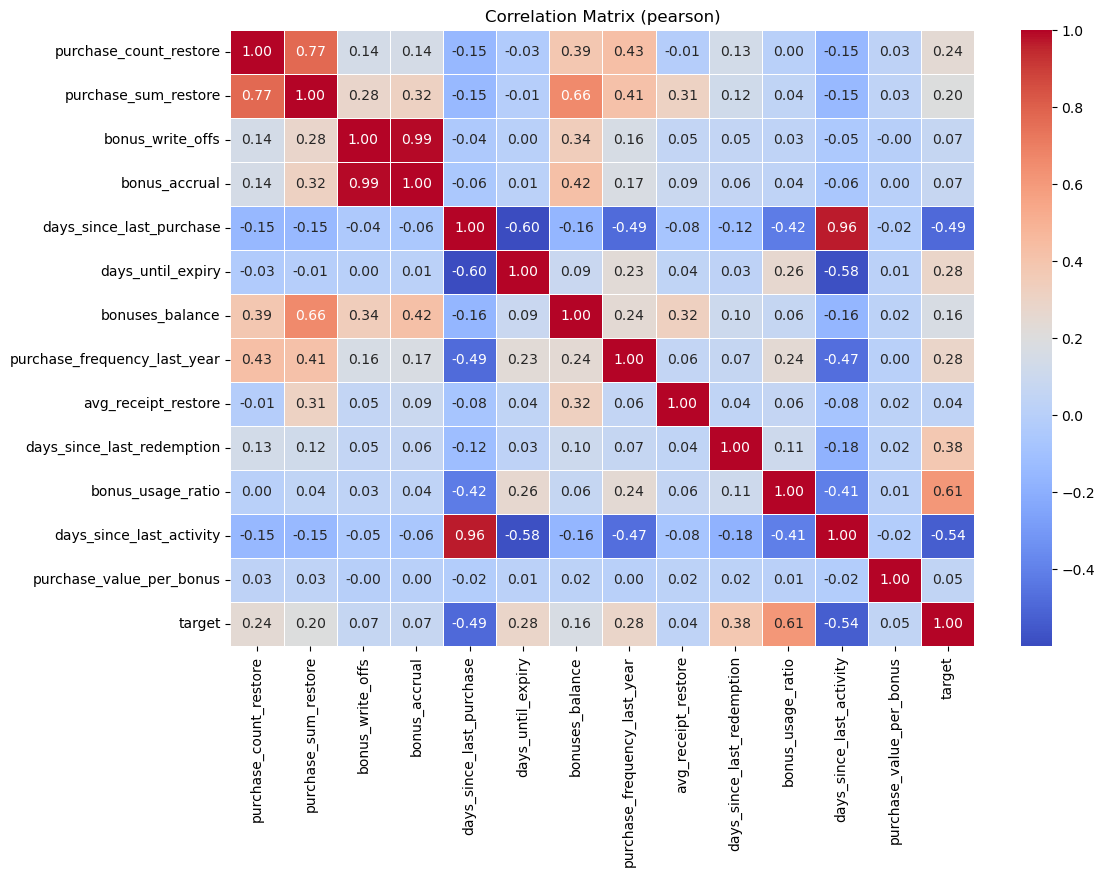

In [ ]:
feature_engineer.plot_correlation_matrix(method="pearson")

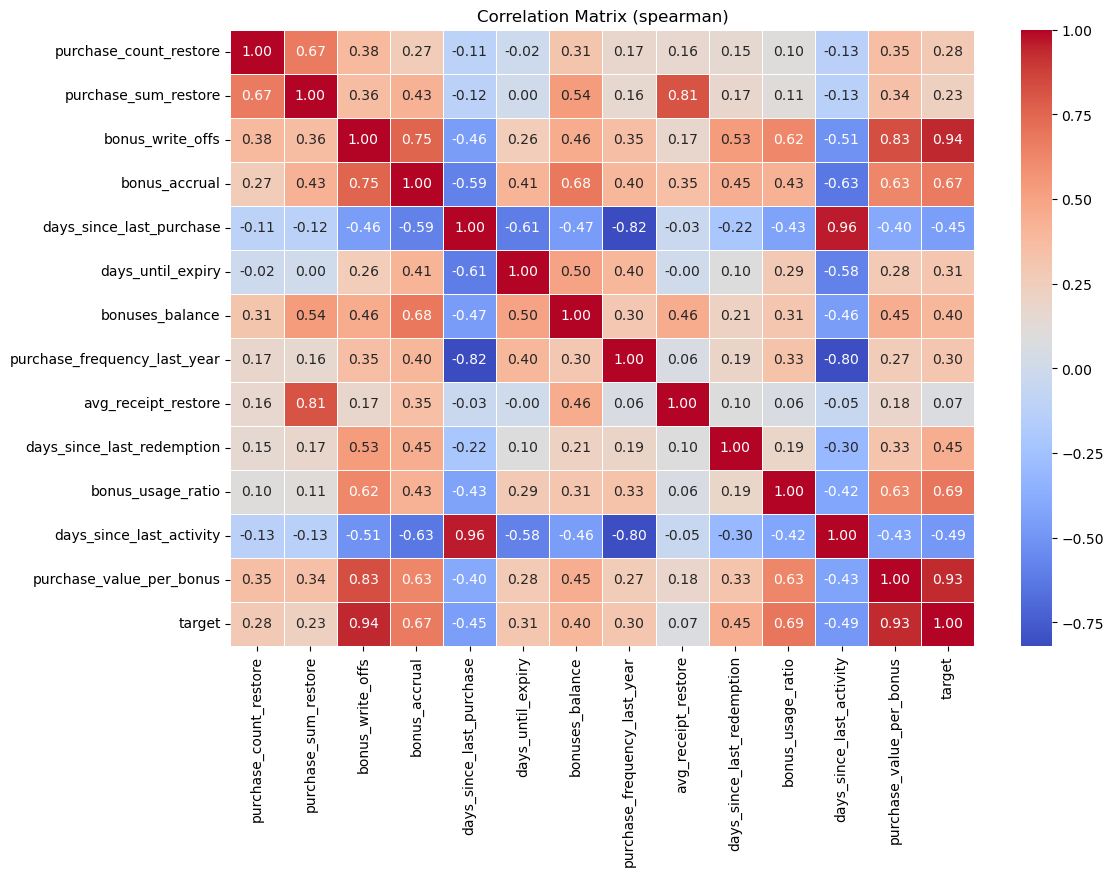

In [17]:
feature_engineer.plot_correlation_matrix(method="spearman")

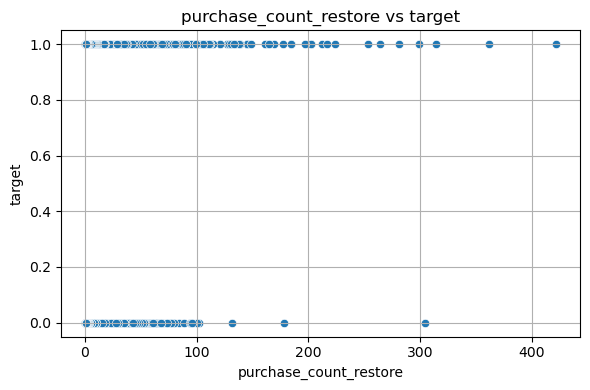

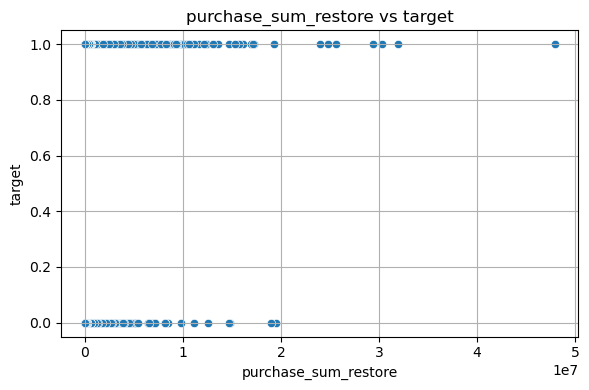

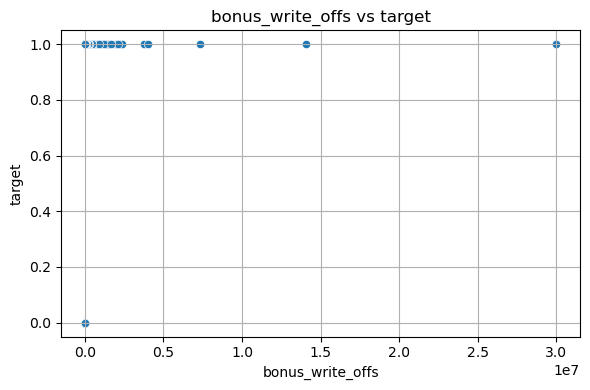

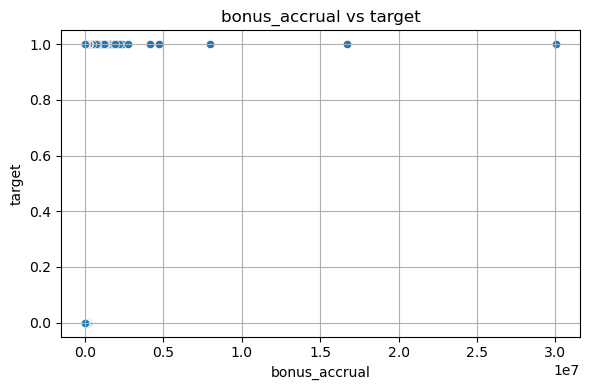

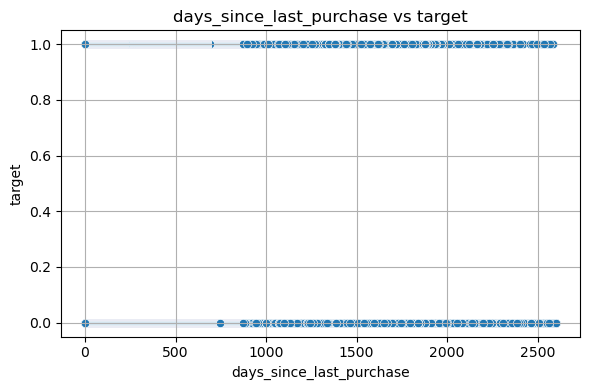

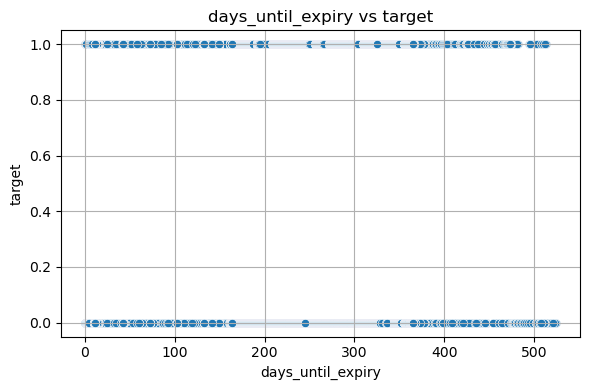

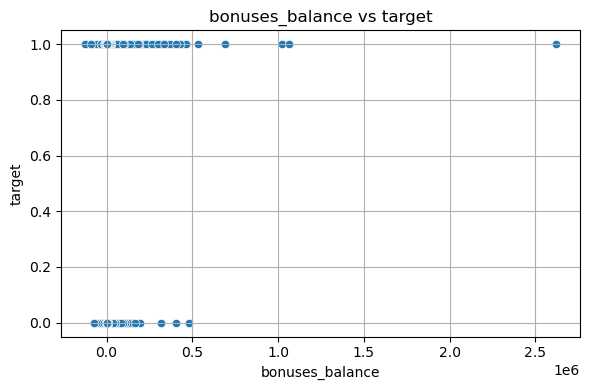

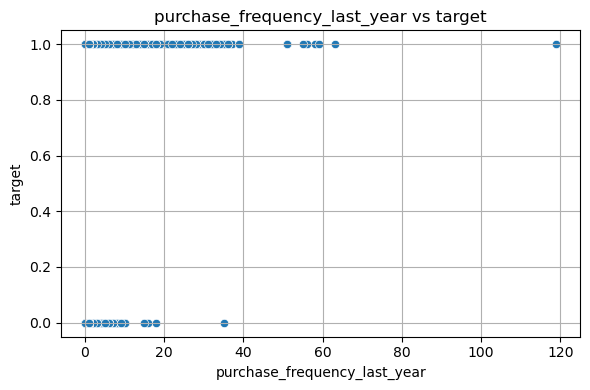

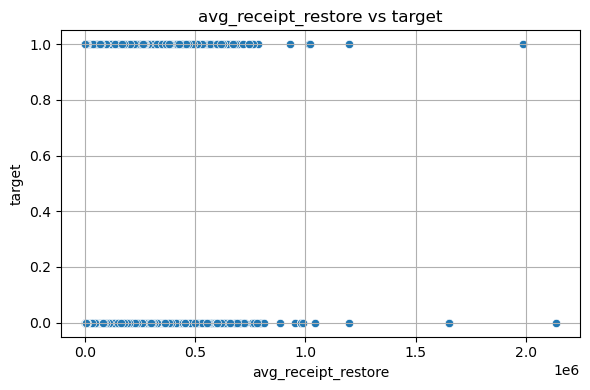

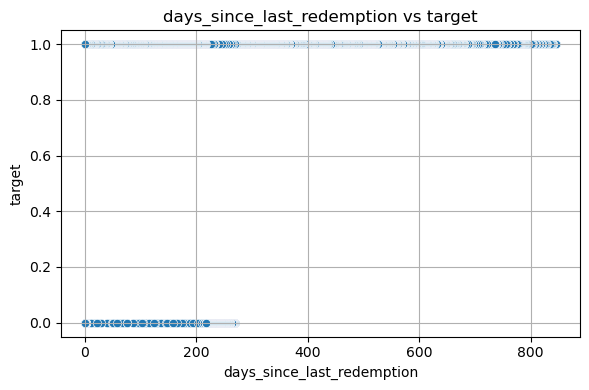

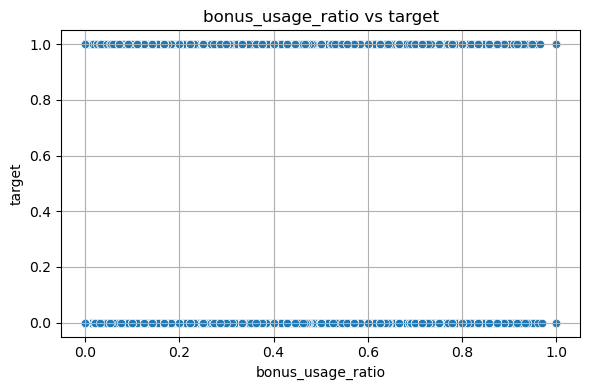

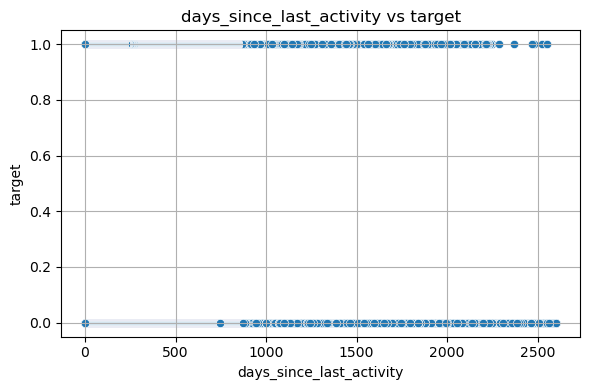

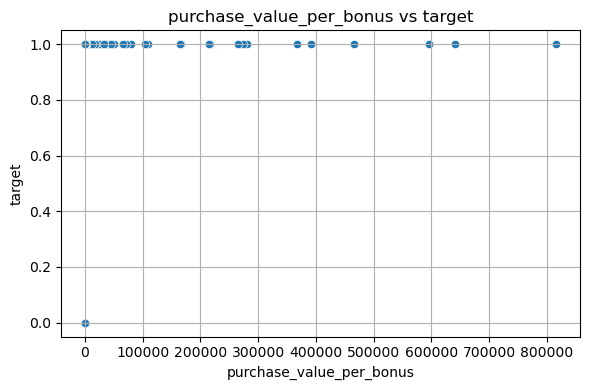

In [ ]:
feature_engineer.plot_target_scatter(target_col="target")

c:\Users\agapenkova\projects\github_projects\elements-of-the-recommendation-system-management-of-bonus-programs\src\feature_engineering.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


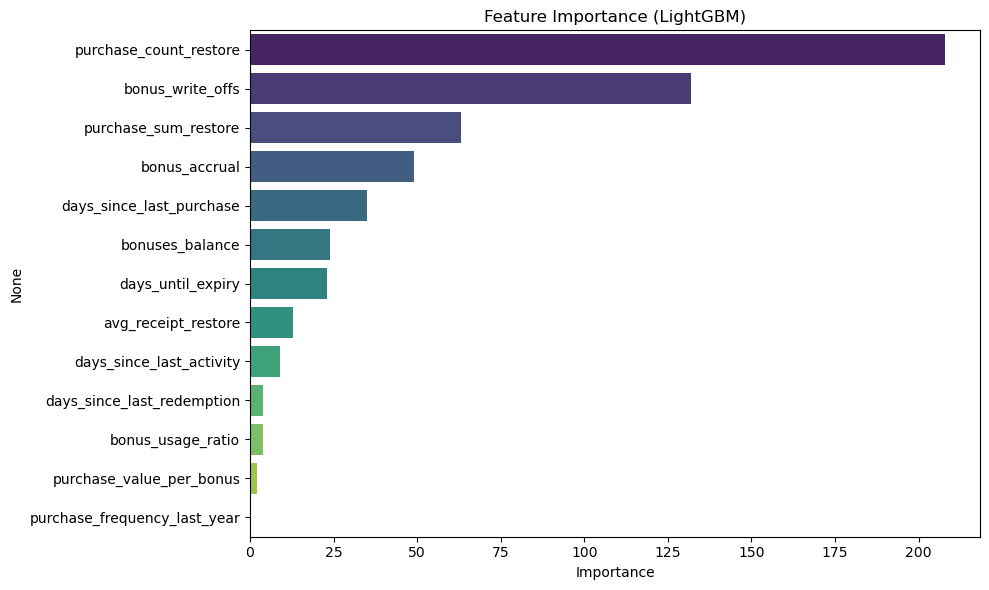

In [9]:
feature_engineer.plot_feature_importance(target_col="target")

In [10]:
# Удаляем избыточные и нерелевантные признаки
columns_to_drop = [
    "bonus_accrual", 
    "purchase_sum_restore",
    "days_since_last_redemption",
    "purchase_frequency_last_year"
]

df_cleaned = df_with_features.drop(columns=columns_to_drop)

### Предобработка

In [ ]:
preprocessor = DataPreprocessor(fill_strategy="zero", scale_method="standard")

df_cleaned = preprocessor.preprocess(df_cleaned)

In [13]:
df_cleaned

,purchase_count_restore,bonus_write_offs,days_since_last_purchase,days_until_expiry,bonuses_balance,avg_receipt_restore,bonus_usage_ratio,days_since_last_activity,purchase_value_per_bonus,target
customer_mindbox_id,,,,,,,,,,
132,-0.064091,-0.062235,0.794884,0.525941,-0.227274,-0.695967,-0.836098,0.844009,-0.046955,0
364,0.941749,0.054210,-1.091888,0.525941,-0.064675,-0.559465,0.528522,-1.085819,-0.028521,1
2206,-0.064091,-0.062235,1.674445,-1.238684,-0.357101,0.644637,-0.229600,1.732117,-0.046955,0
2306,-0.466427,-0.062235,-0.777134,0.525941,-0.258476,-0.856079,0.073649,-0.743287,-0.046955,0
2623,-0.466427,0.072776,-1.069155,2.231350,-0.806481,0.375848,2.802889,-1.038147,-0.040205,1
...,...,...,...,...,...,...,...,...,...,...
362954967,-0.466427,-0.062235,-1.216040,-1.108409,0.739850,2.596902,-0.836098,-1.186459,-0.046955,0
362989745,-0.466427,-0.049483,-1.216040,-1.108409,-0.342990,-0.884472,0.983395,-1.186459,-0.043441,1
363095358,-0.466427,-0.054125,-1.216040,-1.108409,-0.322606,-0.921993,2.802889,-1.186459,-0.044607,1


### Начали обучение и сохраняем результаты по моделям

#### testing + tuning

In [ ]:
target = "target"
X = df_cleaned.drop(columns=[target])
y = df_cleaned[target]

In [15]:
y

customer_mindbox_id
132          0
364          1
2206         0
2306         0
2623         1
            ..
362954967    0
362989745    1
363095358    1
363134777    0
363293445    0
Name: target, Length: 850339, dtype: int32

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=100, random_state=42, verbose=0)
}

In [ ]:
# Тестирование различных моделей
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    metrics = {
        "Model": name,
        "ROC AUC": roc_auc_score(y_test, y_pred_proba),
        "F1-score": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred)
    }
    results.append(metrics)

metrics_df = pd.DataFrame(results)

predictions_df = pd.DataFrame({
    "customer_mindbox_id": X_test.index,
    "Predicted Probability": y_pred_proba,
    "Predicted Class": y_pred,
    "Actual Redemption": y_test.values
})

In [68]:
metrics_df

,Model,ROC AUC,F1-score,Precision,Recall
0,Random Forest,1.000000,1.000000,1.000000,1.000000
1,Gradient Boosting,1.000000,1.000000,1.000000,1.000000
2,XGBoost,0.999998,0.998078,0.998791,0.997366
3,LightGBM,1.000000,0.999342,0.999195,0.999488
4,CatBoost,0.999999,0.999634,1.000000,0.999268


### Optuna: hyperparameter optimization

In [ ]:
target = "target"
X = df_cleaned.drop(columns=[target])
y = df_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
    }

    model = GradientBoostingClassifier(**params, random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    score = roc_auc_score(y_test, y_pred_proba)

    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Best hyperparameters:", best_params)

best_model = GradientBoostingClassifier(**best_params, random_state=42)
best_model.fit(X_train_scaled, y_train)

y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
final_score = roc_auc_score(y_test, y_pred_proba)
print("Final ROC AUC Score:", final_score)

[I 2025-03-25 14:25:13,208] A new study created in memory with name: no-name-291e5a4c-1c6f-4da8-a4c0-cfa23e7147e3
[I 2025-03-25 14:27:27,504] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 218, 'max_depth': 3, 'learning_rate': 0.020010545973317535, 'subsample': 0.8587559382430316, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 1.0.
[I 2025-03-25 14:29:47,652] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 199, 'max_depth': 6, 'learning_rate': 0.02741295118264685, 'subsample': 0.7175245488209029, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 1.0.
[I 2025-03-25 14:30:51,554] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 231, 'max_depth': 3, 'learning_rate': 0.1429283660562885, 'subsample': 0.7094789051925066, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 1.0.
[I 2025-03-25 14:32:57,476] Trial 3 finished with value: 1.0 and parameters: {'n_esti

Best hyperparameters: {'n_estimators': 218, 'max_depth': 3, 'learning_rate': 0.020010545973317535, 'subsample': 0.8587559382430316, 'min_samples_split': 4, 'min_samples_leaf': 1}
Final ROC AUC Score: 1.0


### Обучение модели с лучшими параметрами

In [ ]:
best_params = {
    "n_estimators": 218,
    "max_depth": 3,
    "learning_rate": 0.02,
    "subsample": 0.86,
    "min_samples_split": 4,
    "min_samples_leaf": 1
}
model = Model(best_params)

model.train(X_train, y_train)

metrics = model.evaluate(X_test, y_test)
print("Метрики модели:", metrics)

predictions_df = model.predict(X_test)
predictions_df["customer_mindbox_id"] = X_test.index
print(predictions_df.head())

model.save_model("../models/model_01_04_2025.pkl")

Метрики модели: {'ROC AUC': 1.0, 'F1-score': 1.0, 'Precision': 1.0, 'Recall': 1.0}
                     Predicted Probability  Predicted Class  \
customer_mindbox_id                                           
207131889                         0.993286                1   
2834477                           0.005975                0   
5095734                           0.005975                0   
7798479                           0.993286                1   
3103882                           0.005975                0   

                     customer_mindbox_id  
customer_mindbox_id                       
207131889                      207131889  
2834477                          2834477  
5095734                          5095734  
7798479                          7798479  
3103882                          3103882  


### Использование модели

In [ ]:
loaded_gb = Model.load_model("../models/model_01_04_2025.pkl") 

loaded_model = Model({}) 
loaded_model.model = loaded_gb

In [ ]:
predictions = loaded_model.predict(df_cleaned) 

In [ ]:
predictions

,Predicted Probability,Predicted Class
customer_mindbox_id,,
132,0.005975,0
364,0.993286,1
2206,0.005975,0
2306,0.005975,0
2623,0.993286,1
...,...,...
362954967,0.005975,0
362989745,0.993286,1
363095358,0.993286,1
